# Deep Learning for Object Detection: A Comprehensive Review


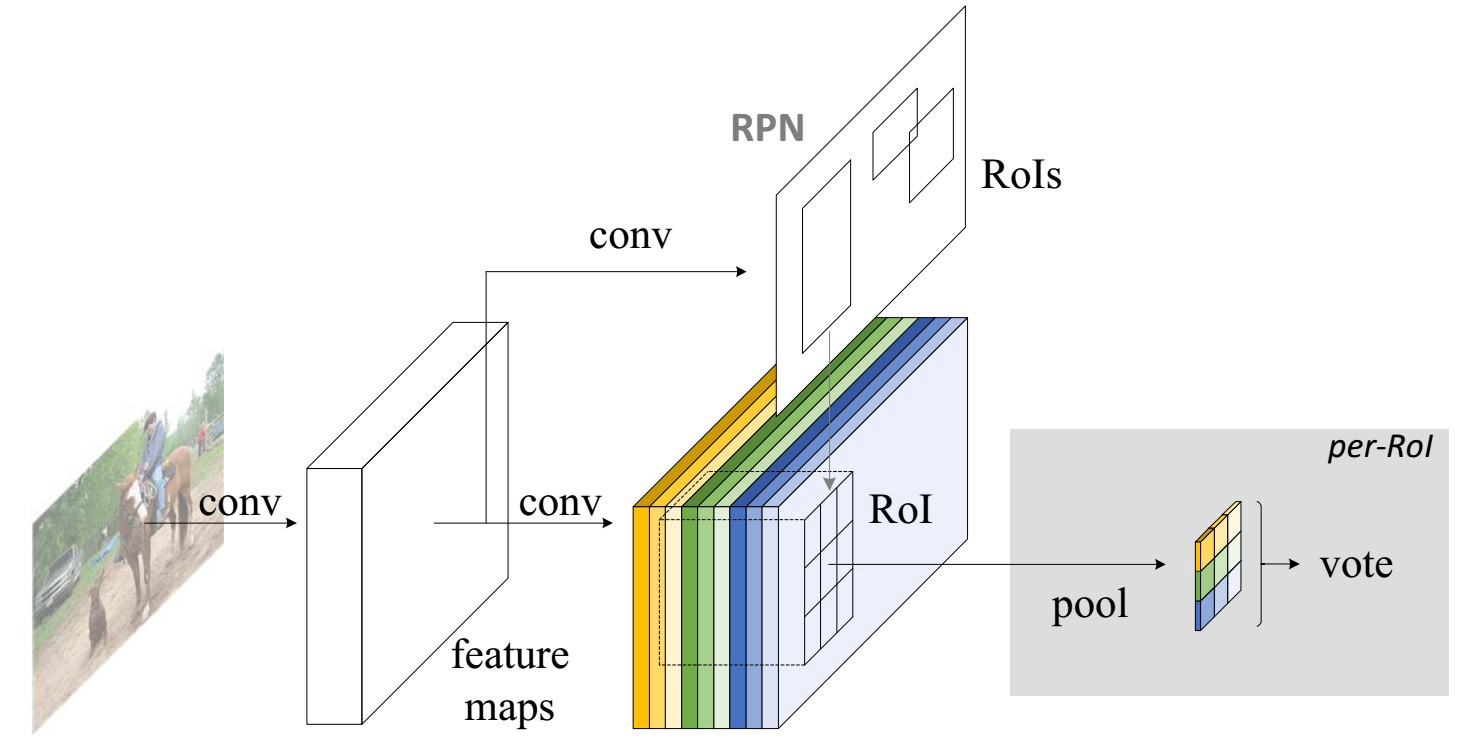

## Object detection 

* Recognizing
* Classifying
* Localizing

Localizing makes object detection a much harder task than image classification

## Possible network type

* Faster R-CNN
* R-FCN 
* SSD

## Predecessor of R-CNN

  
    


#### 1. R-CNN (Region-based Convolutional Neural Network)

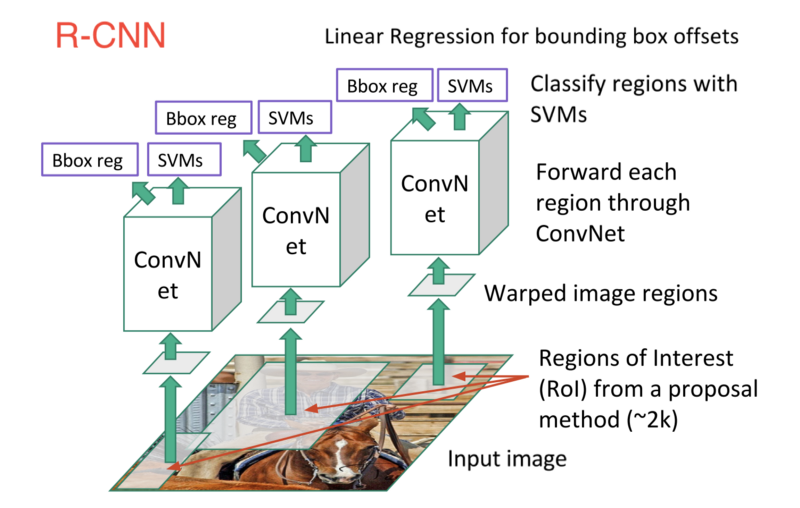

1. Scan input image for possible objects using an algorithm called **Selective Search** generating ~ 2000 region proposal    
2. Run a convolutional neural net (CNN) on top of each of these region proposal
3. Take the output of each CNN 
    1. Feed output in an SVM to classify the region 
    2. Feed output in a linear regressor to tighten the bounding box


Final toughts : **R-CNN very intuitive but very slow**


#### 2.Fast R-CNN

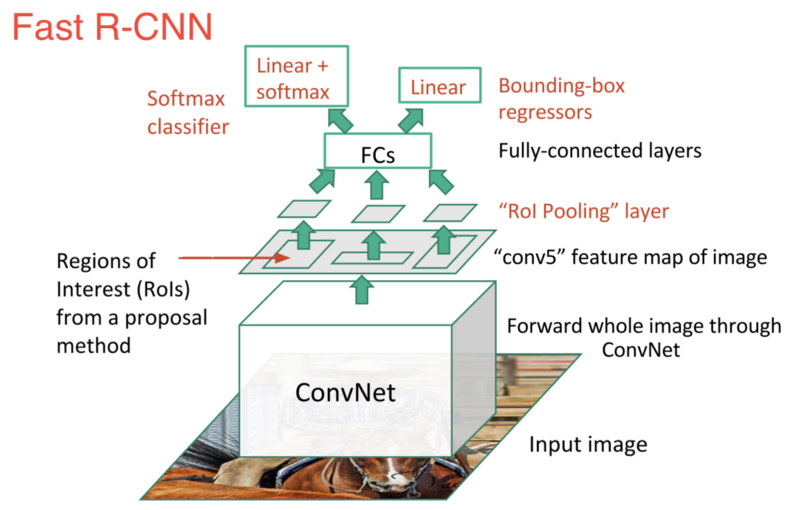

* Improved detection speed throught two mains augmentation:
    1. Preforming feature extraction on image **before** proposing regions (1 CNN over the image rather than 2000 over overlapping region)
    2. Replacing SVM with **Softmax layer** thus extending neural net for prediction rather instead of creating a new model

* Final thoughts : 
    1. Training **one** cnn for entire image
    2. Single softmax layer for classification rather than multiple SVM
    3. **Bottleneck remaining: the selective search algorithm for generating region proposals**

## Faster R-CNN



* Introduction to **RPN (Region Proposal Network)**
   1. Last layer of CNN we added a 3x3 sliding window that moves accross the feature map and maps it to lower dimension
   2. For each sliding window location, it generates **multiple possible regions** based on a k fixed-ratio called **anchor boxes** (default bounding boxes)
   3. Each **region proposal** consist of:
       1. An **"Objectness"** score for that region
       2. 4 coords representing the bouding box of that region
 
Look at each location on feature map, consider k boxes of different size around feature, output if we thing boxes contain object and what are the coordinate.
   
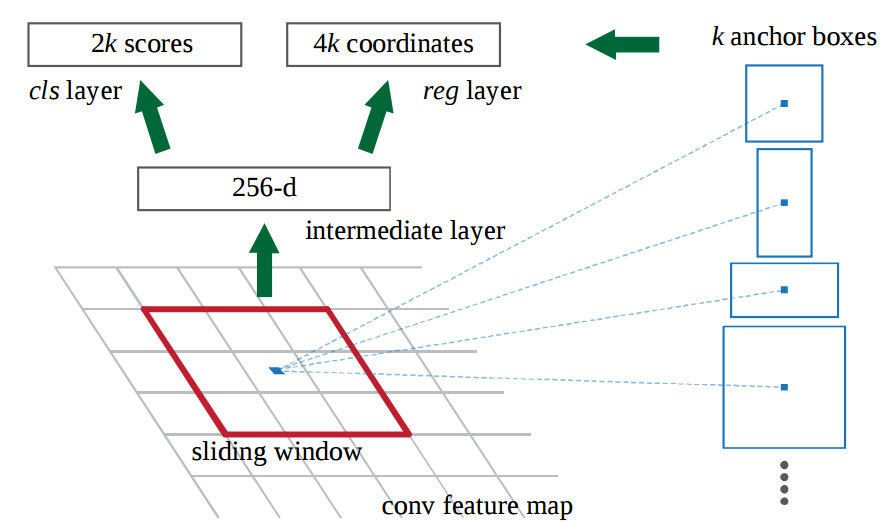
    
2k score : Softmax probability of each k **bounding box** being **"on"** object

The RPN output bounding boxes but does no PREDICTION.
If objectness score above threshold then box coordinate get passed foward as region proposal
Region proposal is then feed to a Fast-RCNN

**Faster R-CNN = RPN + Fast R-CNN**

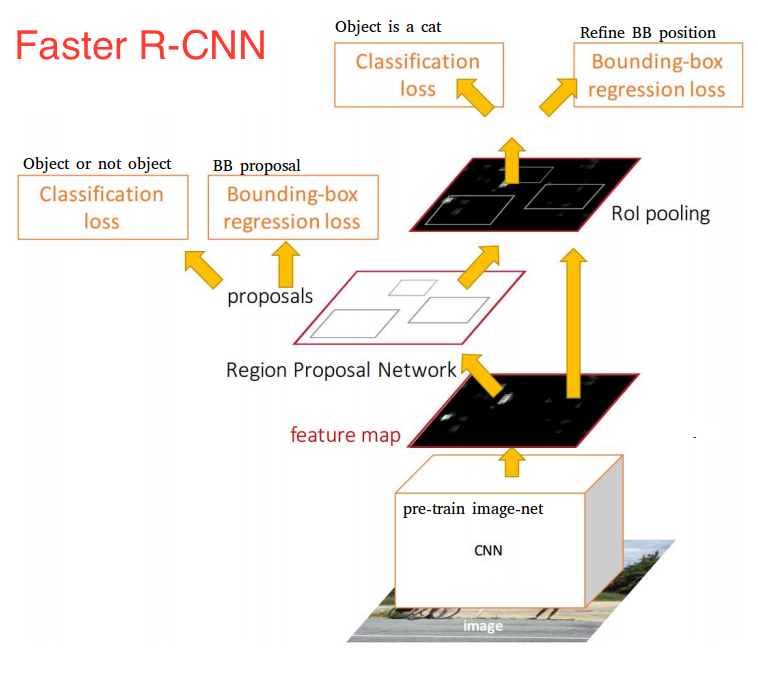




    

Final Though: **Tensorflow’s Faster R-CNN with Inception ResNet is their slowest but most accurate model.**

## R-FCN(Region-based Fully Convolutional Network)

* Increasing speed by maximizing shared computation
* Shares 100% of the computations across every single output

#### Classification of object requires 

**location invariance** i.e cat in image we want to classify cat regardless of location


#### Object detection requires 

**location variance** i.e if the cat is in the top-left corner we want to draw the bounding box


Solution : **R-FCN Solution:position-sensitive score maps.**

* Each position-sensitive score map represent one relative position of one object class
* Many score map might activate on a single image depending on the content of the image

Convolutional feature maps that have been trained to recognize certain parts of each object.

### How does it work

1. Run a CNN iver the input images
2. Add a fully connected layer to generate a **score bank** of the "position -senstive score maps."  There should be k²(C+1) score map where k represents the number of relative positions to divide an object (i.e 3² for a 3x3 grid) and C+1 representing the number of classes plus the background
3. Run a fully convolutional region proposal network (RPN) to generate region of interest (RoI)
4. For each RoI divide it into the same k² bins of subregions as the score maps 
5. For each bin, check the score bank to see if that bin matches the corresponding position of some object. For example, if I’m on the “upper-left” bin, I will grab the score maps that correspond to the “upper-left” corner of an object and average those values in the RoI region. This process is repeated for each class.
6. Once each of the k² bins has an “object match” value for each class, average the bins to get a single score per class.
7. Classify the RoI with a softmax over the remaining C+1 dimensional vector

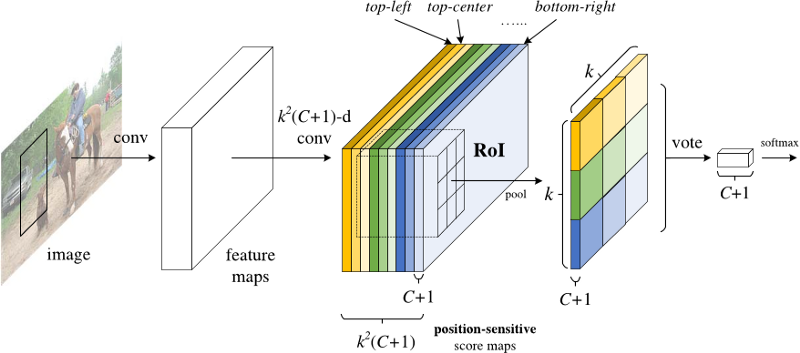

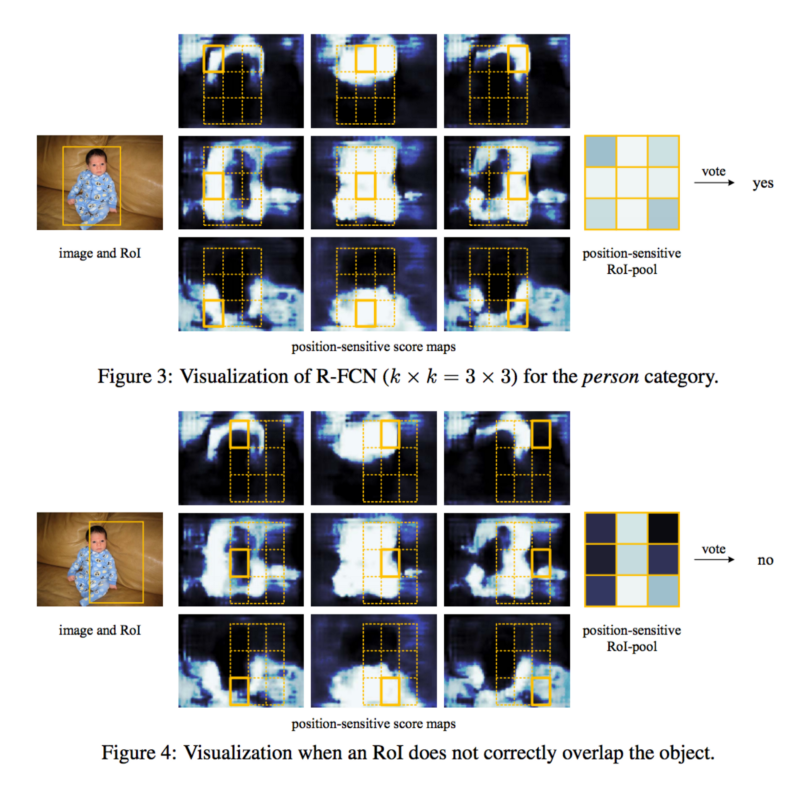

R-FCN considers each region proposal, devides it up into sub-regions and iterates over the sub-region asking : "does this look like the top-left of a baby", "does it look like the top-center of a baby ... ?. And it repeats this for all possible classes. If the sub-regions says "yes, I match up with that part of a baby!" then the RoI gets classified as a baby after a softmax over all the classes.

**As a result, R-FCN is serval times faster than Faster R-CNN, and achieves comparable accuracy.**

## SDD (Single Shot Detector)

* Like R-FCN provides enormous speed gains over Faster R-CNN
* SDD perform regions proposal and region classification in a single shot
  predicting the bounding box and the class as it process the images


Key idea here is **single network (for speed) and no need for region proposals** instead it **uses different bounding boxes and then adjust the bounding box as part of prediction**.

Different bounding box predictions is achieved by each of the last few layers of the network responsible for predictions for progressively smaller bounding box and final prediction is union of all these predictions. 



### Architecture

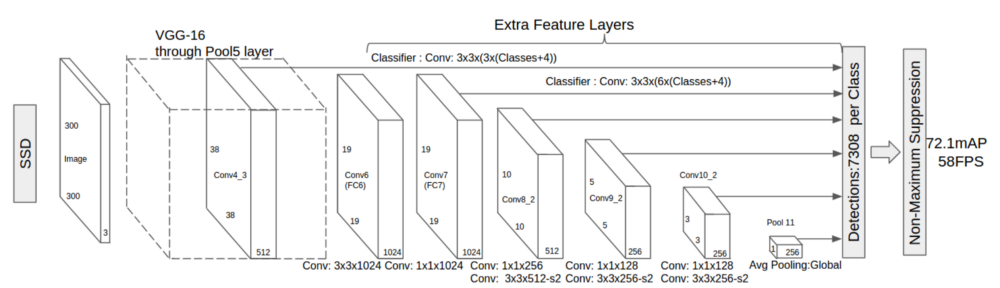

### How does it work 

1. Pass the images through a series of convolutional layers, yeilding several sets of feature maps at different scales (e.g 10X10, then 6x6, then 3x3 ...)
2. For each location in *each* of these feature maps, use a 3x3 convolutional filter to evaluate a small set of *default bounding boxes*. These *default bounding boxes* are essentially equivalent to Faster R-CNN's anchor box.
3. For each box, simultaneously predict
    a) the bounding box offset
    b) the class probability
4. During training, match the ground truth box with the predicted boxes base on [IoU](https://en.wikipedia.org/wiki/Jaccard_index). The best predicted box will be labeled a *"positive"*, along with all other boxes that have an IoU with the truth > 0.5

#### The jaccard Index (Intersection over Union)

The jaccard index, also known as **Intersection over Union** and the **jaccard similarity coefficient** is a statistic used for comparing the similarity and diversity of sample sets


The jaccard coefficient measures similarity between finite sample sets, and is defined as **the size of the intersection divided by the size of the union of the sample sets**

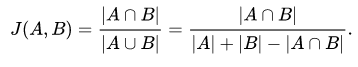

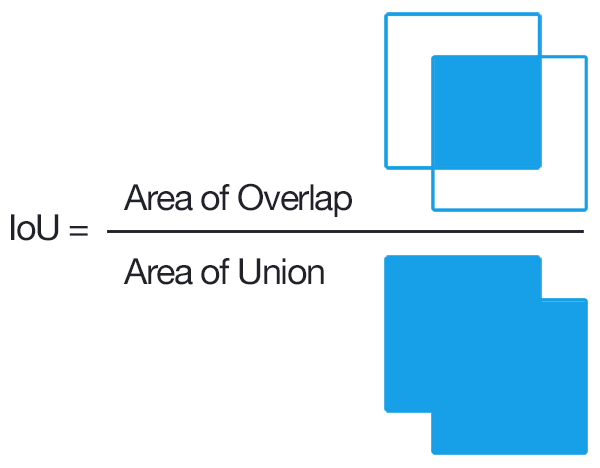

### Training

* SSD **does not make sure** that the object we are trying to classify is realy an object, **no filtering step** (like the RPN does)
* SSD classify and draw bounding boxes from **every single position** in the image, using **multiple different shapes** at **several different scales**. (Generate alot of bounding boxes in which a huge amount of them are negative)

To fix this imbalance, SSD does two things:

1. Use [non-maximum suppression (NMS)](https://docs.microsoft.com/en-us/cognitive-toolkit/Object-Detection-using-Fast-R-CNN#algorithm-details) to **group together** highly-overlapping boxes into a single box. The box with the highest confidence will be the chosen one.
2. Use a technique called [hard negative mining](https://arxiv.org/pdf/1608.02236.pdf) to balance class during training. **Only a subset of the negative examples with the highest training loss(false positive) are used at each iteration during training (3:1 negative to positive ratio)**

#### The Non Maximum Suppresion (NMS)

Object detection methods often **output multiple detections** which fully or partly cover the same object in an image. These ROIs need to be **merged** to be able to **count objects and obtain theur exact locations in the image**. This is done using the NMS technique.

In the SSD context the version of NMS used does not merge the ROIs but instead tries to **identify which ROIs best cover the real locations of an objects (highest confidence)** and discards all the other ROIs.

Detection results before (left) and after (right) Non Maximum Suppression: 

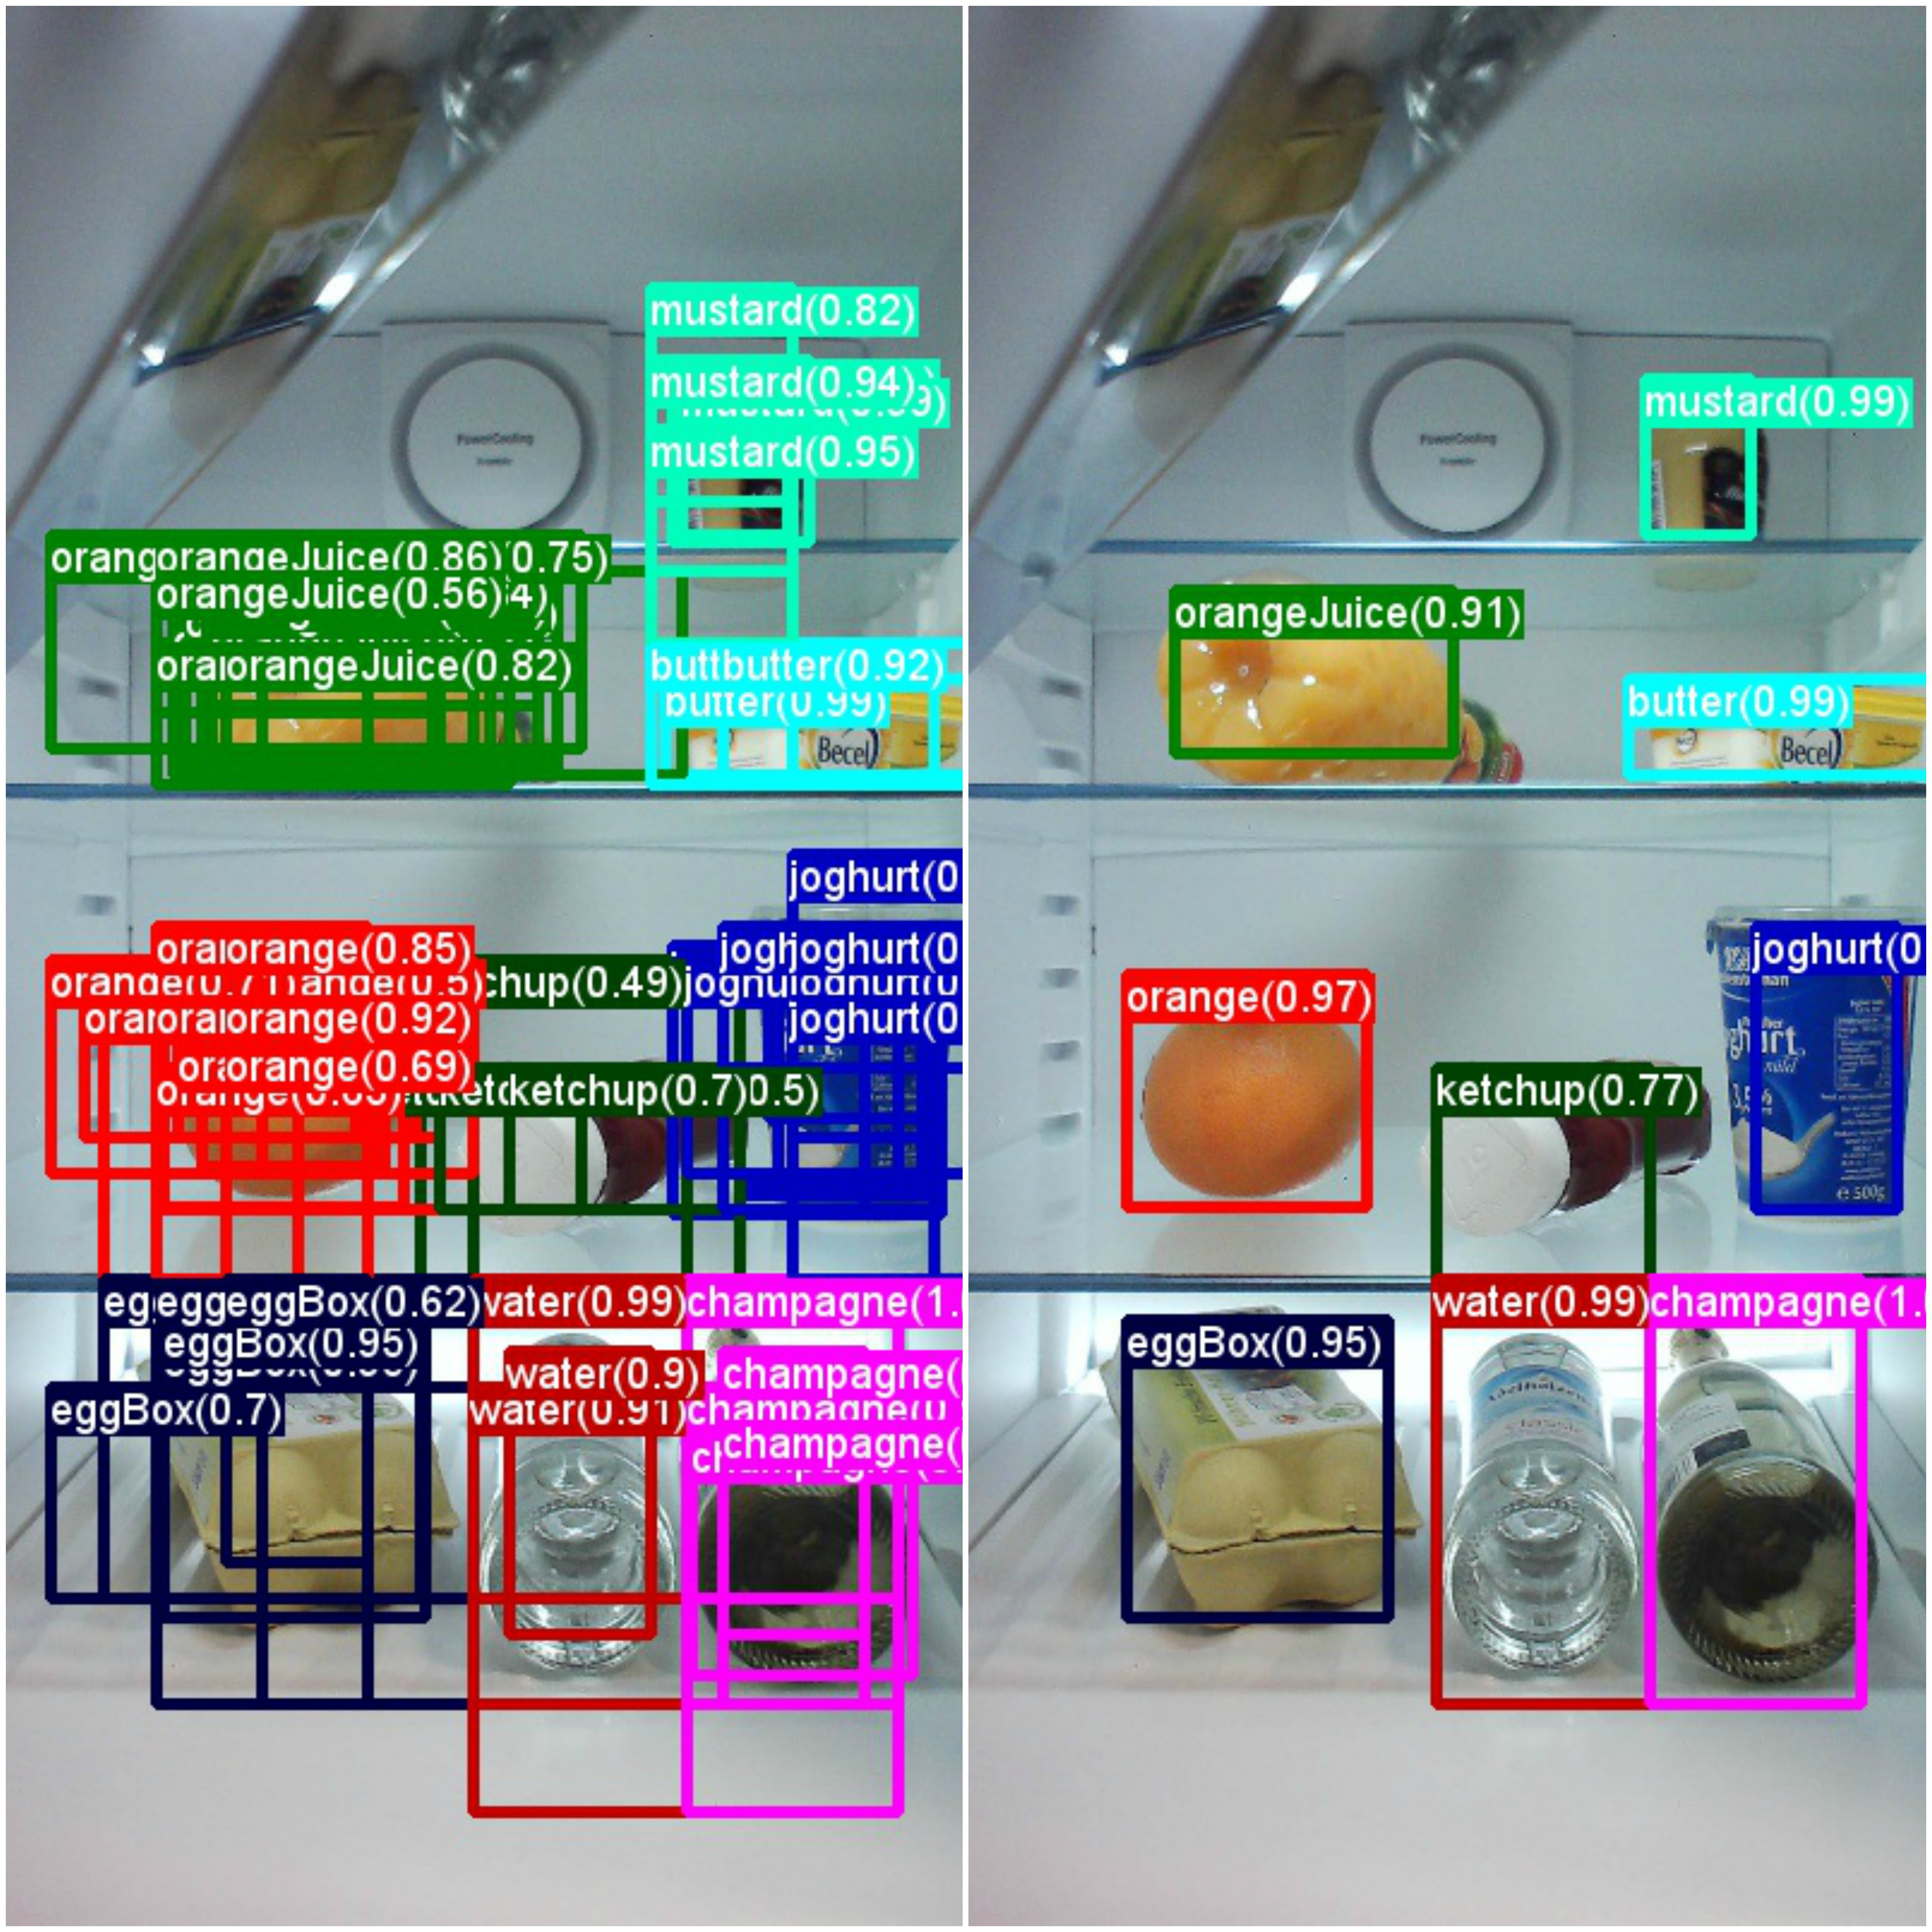

### The extra feature layers

* These varying-size feature maps help capture objects of different sizes

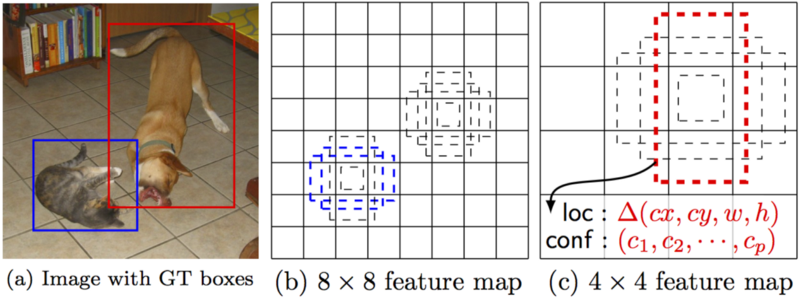

**In smaller feature maps (e.g 4x4), each cell covers a larger region of the image, enabling them to detect larger objects.**

**Region proposal and classification are performed simultaneously**

**Give *p object class* each bounding box is associated with a (4+p)-dimensional vector that ouputs 4 vox offset coordinates and p class probabilities. In the last step softmax is used to classify the object.**





# Vocabulary

* Canonical Model: Is a design pattern used to communicate between different data formats.

# Source 

* https://towardsdatascience.com/deep-learning-for-object-detection-a-comprehensive-review-73930816d8d9
* https://medium.com/@ManishChablani/ssd-single-shot-multibox-detector-explained-38533c27f75f
* https://en.wikipedia.org/wiki/Jaccard_index
* https://arxiv.org/pdf/1512.02325v5.pdf